In [ ]:
#!wget 'https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt'

#Get the class names


In [ ]:
file_path = "/content/categories.txt"

# Open the file and read its contents
with open(file_path, "r") as file:
    classes = [line.strip().replace(' ', '_') for line in file]

# Output the processed data
print(classes)


['apple', 'banana', 'cloud']


#Download the dataset

In [ ]:
!mkdir data


In [ ]:
import urllib.request

def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:
        cls_url = c.replace(' ', '%20')  # Replacing spaces with %20 in class names
        path = base + cls_url + '.npy'
        print("Downloading:", path)
        urllib.request.urlretrieve(path, 'data/' + c + '.npy')


In [ ]:
download()


Downloading: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
Downloading: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
Downloading: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy


#Imports


In [ ]:
import os
import glob
import numpy as np
from tensorflow import keras

from tensorflow.keras import layers
from keras.utils import to_categorical
import tensorflow as tf

#Load the data

In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))


9600


cloud


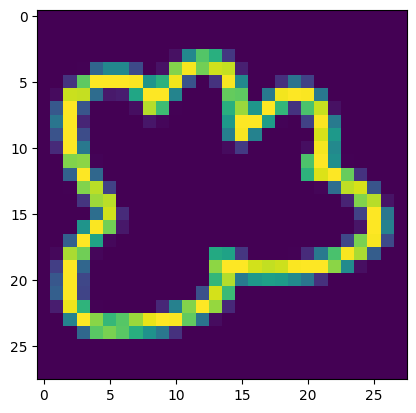

In [ ]:
#show random some data
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Train model

In [ ]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(3, activation='softmax'))
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

In [ ]:
model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=256, verbose=2, epochs=5)

In [ ]:
history = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
34/34 - 9s - loss: 0.0745 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1180 - val_top_k_categorical_accuracy: 1.0000 - 9s/epoch - 253ms/step
Epoch 2/5
34/34 - 5s - loss: 0.0666 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1194 - val_top_k_categorical_accuracy: 1.0000 - 5s/epoch - 146ms/step
Epoch 3/5
34/34 - 6s - loss: 0.0602 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1151 - val_top_k_categorical_accuracy: 1.0000 - 6s/epoch - 184ms/step
Epoch 4/5
34/34 - 5s - loss: 0.0508 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1196 - val_top_k_categorical_accuracy: 1.0000 - 5s/epoch - 151ms/step
Epoch 5/5
34/34 - 6s - loss: 0.0517 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1179 - val_top_k_categorical_accuracy: 1.0000 - 6s/epoch - 166ms/step


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'top_k_categorical_accuracy', 'val_loss', 'val_top_k_categorical_accuracy'])


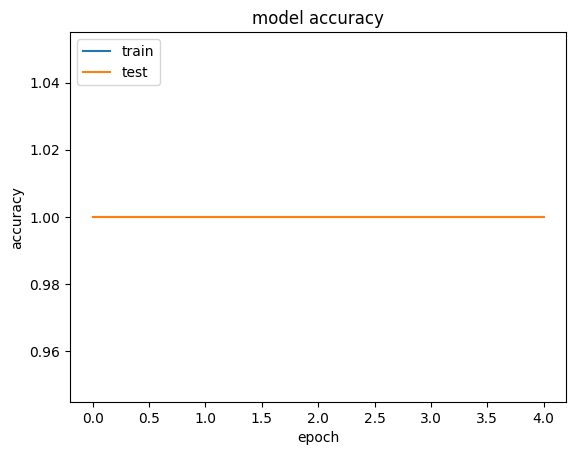

In [ ]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

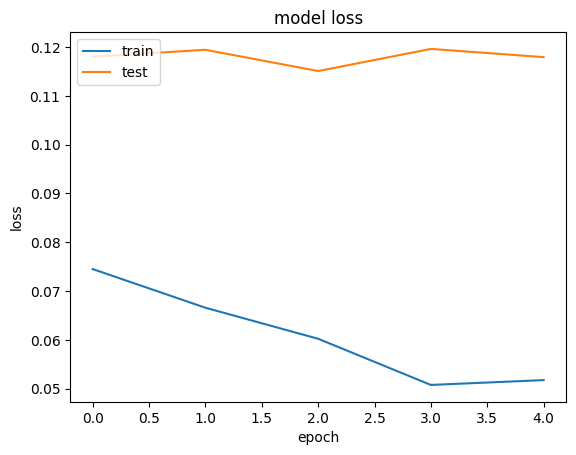

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Testing

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


1/1 [==============================] - 0s 111ms/step
['banana', 'apple', 'cloud']


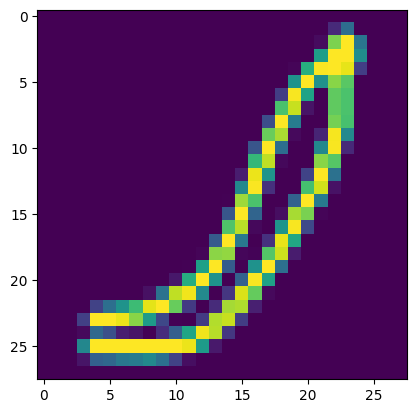

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [ ]:
!pip install tensorflowjs

#Save and convert

In [ ]:
model.save('detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras detection.h5 model/

2023-11-09 05:43:04.878644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 05:43:04.878761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 05:43:04.878851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 05:43:07.111890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
 

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/class_names.txt (stored 0%)


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>